Course-level (program data)

This is absolutely worth it, but mainly for:

Better differentiation between similar institutions:
Two universities might look the same at institution-level (ENG_RATIO, cost, retention), but one has more engineering programs or lower typical debt in those programs. Your course-level file already contains that (DEBT_* fields by CIP, etc.). That’s extra signal your current model doesn’t see.

Better “story” for the user:
Your PPT explicitly talks about “Which stream at this college is the best fit?” and program-level outcomes (debt, earnings). 


Even if the ROC AUC only improves a bit, being able to say “this college has 8 engineering majors with relatively low debt” is a big win for the product.

For pure VALUE_LABEL prediction (affordable + good quality), course-level aggregates might give a modest metric bump, because QUALITY_SCORE and COSTT4_A already encode a lot. But they’re definitely useful as extra features and for the final ranking and explanation layer.

Location thing (radius filter)

This is less about improving ROC AUC and more about:

Hard constraints (“I only want colleges within 200 km of home”).

A weighted objective (“location = 4/5 importance”).

You wouldn’t usually feed a specific user’s lat/lon into the training ML model (since every user can have a different home), but you:

Use location for filtering + scoring at recommendation time.

Optionally include generic location features (REGION, LOCALE) in the ML model.

So:

Course-level data → can help model and product.

Location radius filter → mainly helps product (user-facing) + ranking, not model AUC.

2. How I’d think about incorporating them

If I were designing this:

Augment institution-level X with course aggregates
From merged_course_level.csv (already engineering-only), build per-UNITID features like:

ENG_PROG_COUNT = number of distinct engineering programs (CIPCODE nunique).

ENG_CRED_LEVELS = number of different credential levels (bachelor, master, etc.).

DEBT_ALL_STGP_ANY_MDN_mean/min/max = typical program-level debt stats for engineering.
Then merge onto your inst_df and include them as features in the VALUE_LABEL classifier.

Keep VALUE_LABEL definition as institution-level
Still define something like “affordable + high quality” from COSTT4_A and QUALITY_SCORE and possibly outcomes = target y. Don’t mix course-level into the label to avoid weird leakage.

Use location at serving time
Implement:

annotate_distance(df, user_lat, user_lon) → add DISTANCE_KM.

filter_by_radius(df, user_lat, user_lon, radius_km) → only nearby schools.
Then let your user give a location weight (0–5) and use DISTANCE_KM in the final USER_SCORE.

Multi-model comparison view
For each model (Logistic, RF, GB, KNN), after GridSearchCV:

Store cv_results_ into a DataFrame.

Plot a bar chart of mean CV ROC AUC for the top N hyperparameter combos.

Also plot a bar chart of test ROC AUC per model.

That last bit matches what you described: “graph for each model that shows how good each hps performed”.

3. Fresh notebook code: institution + course + location + CV graphs

Here’s a single big code block you can paste into a new notebook.

You’ll need:

Processed-MERGED2023_24_PP.csv (institution-level, like in your earlier notebook)

merged_course_level.csv (the file you just uploaded)

If the filenames differ, just change the two constants at the top.

Institution-level shape: (5650, 33)
Course-level shape: (121798, 71)
Dropped 2401 invalid UNITID rows from course_df.
Aggregated course-level shape: (2875, 8)
Merged df shape: (5650, 41)
Median COSTT4_A: 24517.0
Median QUALITY_SCORE: 0.3101671281203574
VALUE_LABEL distribution:
VALUE_LABEL
0    3902
1    1748
Name: count, dtype: int64
Using features: ['ENG_RATIO', 'STEM_RATIO', 'ENG_HEAVY', 'STEM_HEAVY', 'UGDS', 'UGDS_MEN', 'UGDS_WOMEN', 'DIVERSITY_SCORE', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'TUITION_GAP', 'RET_FT4', 'GRAD_RATE', 'ADM_RATE', 'MD_EARN_WNE_P10', 'CONTROL', 'IS_PUBLIC', 'IS_PRIVATE', 'IS_FORPROFIT', 'ENG_PROG_COUNT', 'ENG_CRED_LEVELS', 'DEBT_ALL_STGP_ANY_MDN_mean', 'DEBT_ALL_STGP_ANY_MDN_min', 'DEBT_ALL_STGP_ANY_MDN_max', 'DEBT_ALL_PP_ANY_MDN_mean', 'DEBT_ALL_PP_ANY_MDN_min', 'DEBT_ALL_PP_ANY_MDN_max']
Train size: 4520
Test size: 1130
Running LogisticRegression
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best params for LogisticRegression:
{'clf__C': 1, 'c

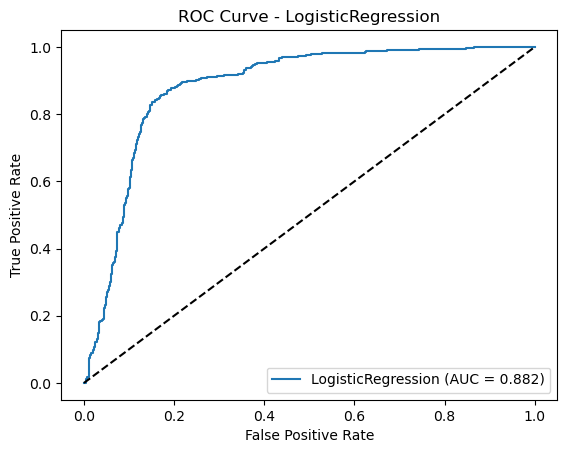

Running RandomForest
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best params for RandomForest:
{'clf__class_weight': 'balanced', 'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Best CV ROC AUC: 0.993

Test classification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       780
           1       0.93      0.90      0.91       350

    accuracy                           0.95      1130
   macro avg       0.94      0.93      0.94      1130
weighted avg       0.95      0.95      0.95      1130

Test ROC AUC: 0.9912087912087911
Confusion matrix:
[[756  24]
 [ 35 315]]


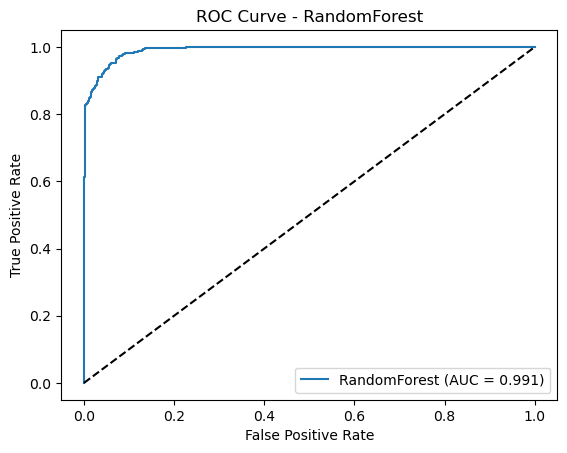

Running GradientBoosting
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best params for GradientBoosting:
{'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200}
Best CV ROC AUC: 0.993

Test classification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       780
           1       0.93      0.92      0.93       350

    accuracy                           0.95      1130
   macro avg       0.95      0.94      0.95      1130
weighted avg       0.95      0.95      0.95      1130

Test ROC AUC: 0.9912417582417583
Confusion matrix:
[[756  24]
 [ 28 322]]


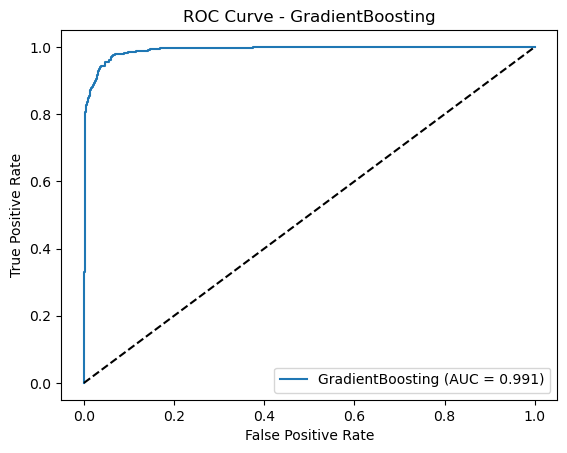

Running KNN
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best params for KNN:
{'clf__n_neighbors': 15, 'clf__weights': 'distance'}
Best CV ROC AUC: 0.931

Test classification report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       780
           1       0.79      0.73      0.76       350

    accuracy                           0.86      1130
   macro avg       0.84      0.82      0.83      1130
weighted avg       0.85      0.86      0.85      1130

Test ROC AUC: 0.934139194139194
Confusion matrix:
[[714  66]
 [ 96 254]]


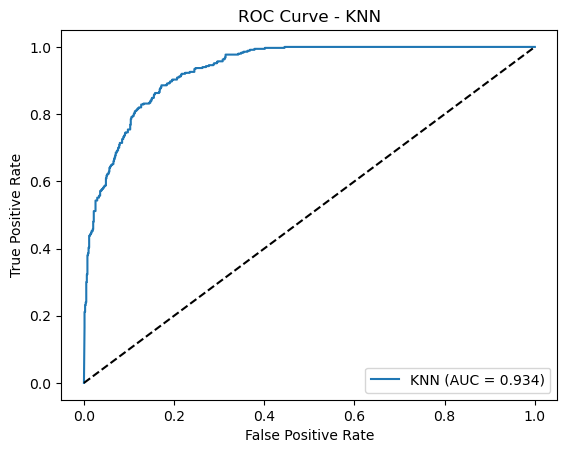

Selected main value model: RandomForest (CV ROC AUC = 0.993, test ROC AUC = 0.991)


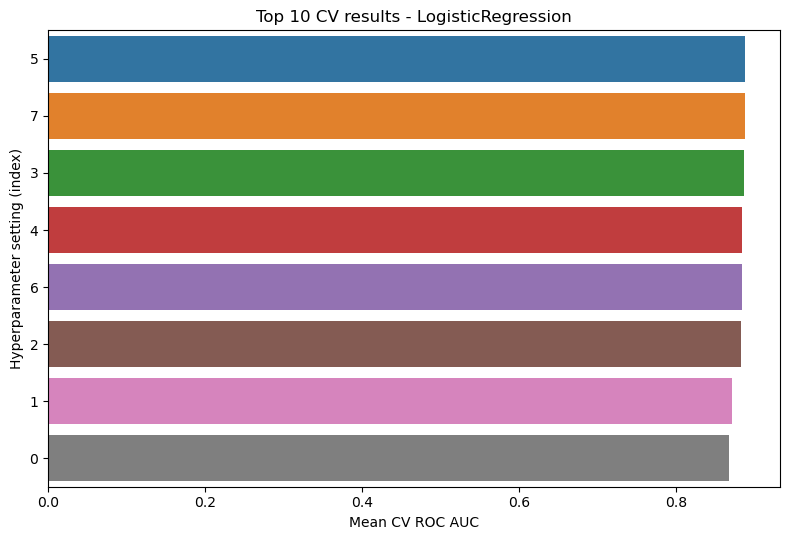


Top 10 hyperparameter settings for LogisticRegression:


,mean_test_score,std_test_score,params
5,0.887689,0.006006,"{'clf__C': 1, 'clf__class_weight': 'balanced'}"
7,0.887630,0.006044,"{'clf__C': 10, 'clf__class_weight': 'balanced'}"
3,0.886296,0.006034,"{'clf__C': 0.1, 'clf__class_weight': 'balanced'}"
4,0.884133,0.006001,"{'clf__C': 1, 'clf__class_weight': None}"
6,0.884132,0.006052,"{'clf__C': 10, 'clf__class_weight': None}"
2,0.882902,0.006079,"{'clf__C': 0.1, 'clf__class_weight': None}"
1,0.870345,0.006649,"{'clf__C': 0.01, 'clf__class_weight': 'balanced'}"
0,0.867212,0.007212,"{'clf__C': 0.01, 'clf__class_weight': None}"


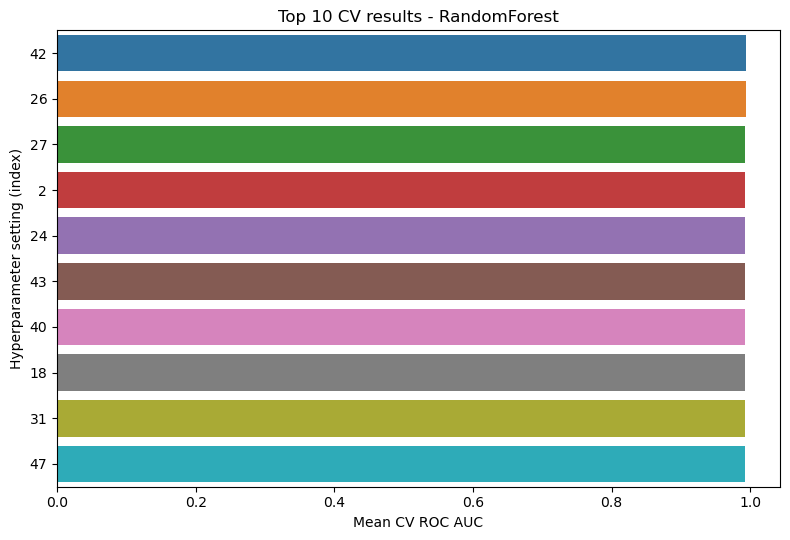


Top 10 hyperparameter settings for RandomForest:


,mean_test_score,std_test_score,params
42,0.993143,0.001832,"{'clf__class_weight': 'balanced', 'clf__max_de..."
26,0.993126,0.001877,"{'clf__class_weight': 'balanced', 'clf__max_de..."
27,0.993024,0.001834,"{'clf__class_weight': 'balanced', 'clf__max_de..."
2,0.993015,0.001934,"{'clf__class_weight': None, 'clf__max_depth': ..."
24,0.993014,0.001822,"{'clf__class_weight': 'balanced', 'clf__max_de..."
43,0.993003,0.001822,"{'clf__class_weight': 'balanced', 'clf__max_de..."
40,0.992998,0.001801,"{'clf__class_weight': 'balanced', 'clf__max_de..."
18,0.992978,0.001879,"{'clf__class_weight': None, 'clf__max_depth': ..."
31,0.992962,0.001768,"{'clf__class_weight': 'balanced', 'clf__max_de..."
47,0.992948,0.001732,"{'clf__class_weight': 'balanced', 'clf__max_de..."


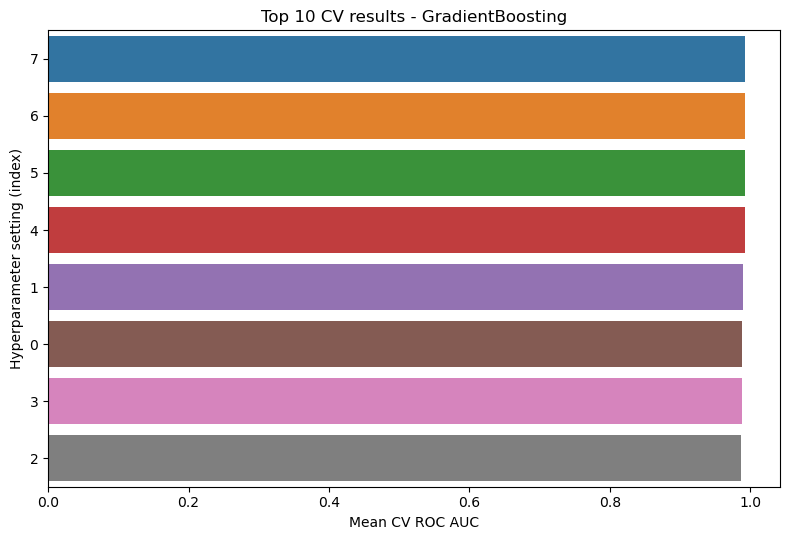


Top 10 hyperparameter settings for GradientBoosting:


,mean_test_score,std_test_score,params
7,0.992643,0.002621,"{'clf__learning_rate': 0.1, 'clf__max_depth': ..."
6,0.991889,0.003891,"{'clf__learning_rate': 0.1, 'clf__max_depth': ..."
5,0.991820,0.002896,"{'clf__learning_rate': 0.1, 'clf__max_depth': ..."
4,0.991818,0.003164,"{'clf__learning_rate': 0.1, 'clf__max_depth': ..."
1,0.990273,0.003401,"{'clf__learning_rate': 0.01, 'clf__max_depth':..."
0,0.988460,0.003420,"{'clf__learning_rate': 0.01, 'clf__max_depth':..."
3,0.988237,0.007497,"{'clf__learning_rate': 0.01, 'clf__max_depth':..."
2,0.987126,0.007279,"{'clf__learning_rate': 0.01, 'clf__max_depth':..."


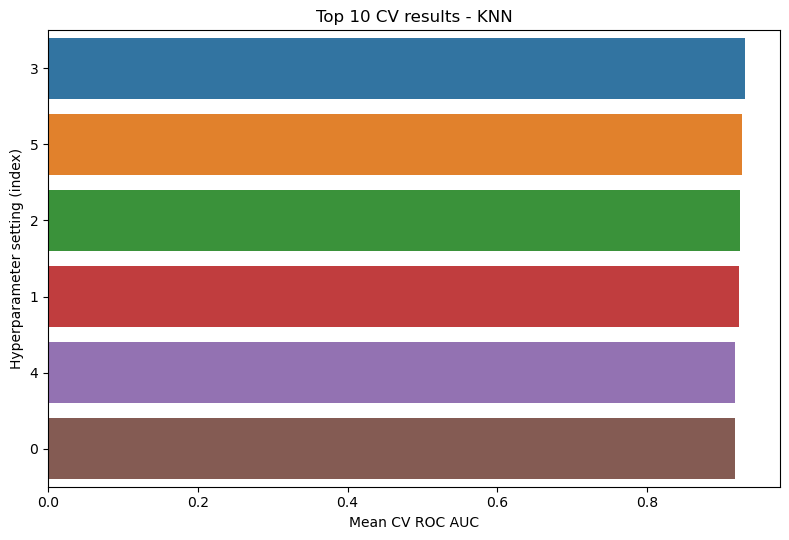


Top 10 hyperparameter settings for KNN:


,mean_test_score,std_test_score,params
3,0.931082,0.008541,"{'clf__n_neighbors': 15, 'clf__weights': 'dist..."
5,0.926813,0.010279,"{'clf__n_neighbors': 25, 'clf__weights': 'dist..."
2,0.924619,0.008775,"{'clf__n_neighbors': 15, 'clf__weights': 'unif..."
1,0.922240,0.009598,"{'clf__n_neighbors': 5, 'clf__weights': 'dista..."
4,0.917801,0.010457,"{'clf__n_neighbors': 25, 'clf__weights': 'unif..."
0,0.917296,0.009579,"{'clf__n_neighbors': 5, 'clf__weights': 'unifo..."


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


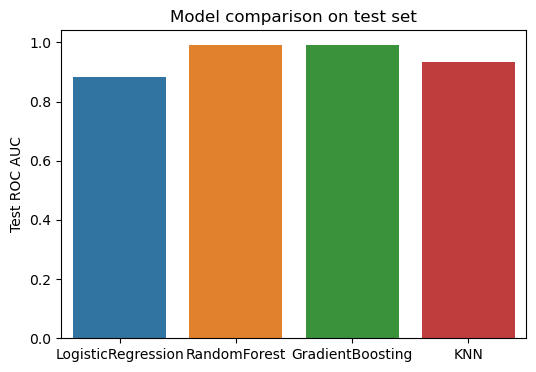

,INSTNM,CITY,STABBR,SECTOR,COSTT4_A,ENG_RATIO,ENG_PROG_COUNT,p_value_model,USER_SCORE
5015,University of Florida-Online,Gainesville,FL,Public,17036.0,0.000000,17.0,0.863653,0.773982
579,University of Florida,Gainesville,FL,Public,21719.0,0.138414,17.0,0.322690,0.685919
640,University of South Florida,Tampa,FL,Public,22301.0,0.056706,12.0,0.913289,0.674641
552,University of Central Florida,Orlando,FL,Public,22819.0,0.083300,12.0,0.811673,0.663027
578,Florida State University,Tallahassee,FL,Public,23683.0,0.038504,8.0,0.897393,0.621391
3903,Embry-Riddle Aeronautical University-Worldwide,Daytona Beach,FL,Private,24015.0,0.059000,10.0,0.672509,0.481035
4932,DeVry University-Florida,Orlando,FL,For-profit,24517.0,0.009200,5.0,0.777734,0.441696
5128,Florida Career College-Jacksonville,Jacksonville,FL,For-profit,24517.0,0.000000,3.0,0.004181,0.416203
5131,Florida Career College-Orlando,Orlando,FL,For-profit,24517.0,0.000000,3.0,0.005894,0.390775
5127,Florida Career College-Tampa,Tampa,FL,For-profit,24517.0,0.000000,3.0,0.005894,0.380575


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# -------------------------------------------------------------------
# 1. Paths & basic config
# -------------------------------------------------------------------

INSTITUTION_CSV = "institute_most_recent_processed.csv"   # <-- change if needed
COURSE_CSV      = "merged_course_level.csv"          # <-- change if needed

# -------------------------------------------------------------------
# 2. Load & merge institution-level and course-level features
# -------------------------------------------------------------------

inst_df = pd.read_csv(INSTITUTION_CSV)
course_df = pd.read_csv(COURSE_CSV, low_memory=False)

print("Institution-level shape:", inst_df.shape)
print("Course-level shape:", course_df.shape)

# ---- Make UNITID a consistent integer key ----

# Institution data
inst_df["UNITID"] = pd.to_numeric(inst_df["UNITID"], errors="coerce")
inst_df = inst_df.dropna(subset=["UNITID"])
inst_df["UNITID"] = inst_df["UNITID"].astype(int)

# Course-level data
course_df["UNITID"] = pd.to_numeric(course_df["UNITID"], errors="coerce")
before = len(course_df)
course_df = course_df.dropna(subset=["UNITID"])
after = len(course_df)
print(f"Dropped {before - after} invalid UNITID rows from course_df.")
course_df["UNITID"] = course_df["UNITID"].astype(int)

# -------------------------------------------------------------------
# 3. Aggregate course-level features to institution level
# -------------------------------------------------------------------

# Columns we’d like to use for debt stats
agg_cols = [
    "DEBT_ALL_STGP_ANY_MDN",
    "DEBT_ALL_PP_ANY_MDN",
]

# Warn if missing
for col in agg_cols:
    if col not in course_df.columns:
        print(f"Warning: {col} not found in course-level data")

# Coerce debt columns to numeric (strings like 'PrivacySuppressed' -> NaN)
for col in agg_cols:
    if col in course_df.columns:
        course_df[col] = pd.to_numeric(course_df[col], errors="coerce")

# Build subset with only relevant columns
base_cols_for_course = ["UNITID", "CIPCODE", "CREDLEV"]
course_df_subset_cols = base_cols_for_course + [c for c in agg_cols if c in course_df.columns]
course_df_subset = course_df[course_df_subset_cols].copy()

# Aggregation dictionary
agg_dict = {
    "CIPCODE": "nunique",   # number of distinct engineering programs
    "CREDLEV": "nunique",   # number of distinct credential levels
}
if "DEBT_ALL_STGP_ANY_MDN" in course_df_subset.columns:
    agg_dict["DEBT_ALL_STGP_ANY_MDN"] = ["mean", "min", "max"]
if "DEBT_ALL_PP_ANY_MDN" in course_df_subset.columns:
    agg_dict["DEBT_ALL_PP_ANY_MDN"] = ["mean", "min", "max"]

course_agg = course_df_subset.groupby("UNITID").agg(agg_dict)

# Flatten MultiIndex columns
course_agg.columns = [
    "_".join([str(c) for c in col if c]) if isinstance(col, tuple) else col
    for col in course_agg.columns
]

course_agg = course_agg.rename(columns={
    "CIPCODE_nunique": "ENG_PROG_COUNT",
    "CREDLEV_nunique": "ENG_CRED_LEVELS"
})

print("Aggregated course-level shape:", course_agg.shape)

# Merge onto institution dataframe
df = inst_df.merge(course_agg, on="UNITID", how="left")
print("Merged df shape:", df.shape)

# -------------------------------------------------------------------
# 4. Define target label (VALUE_LABEL) and feature set
# -------------------------------------------------------------------

# Value label: affordable + good quality (you can tweak thresholds later)
cost_med = df["COSTT4_A"].median()
quality_med = df["QUALITY_SCORE"].median()
print("Median COSTT4_A:", cost_med)
print("Median QUALITY_SCORE:", quality_med)

df["VALUE_LABEL"] = (
    (df["COSTT4_A"] <= cost_med) &
    (df["QUALITY_SCORE"] >= quality_med)
).astype(int)

print("VALUE_LABEL distribution:")
print(df["VALUE_LABEL"].value_counts(dropna=False))

# Base institution-level features
base_features = [
    "ENG_RATIO", "STEM_RATIO",
    "ENG_HEAVY", "STEM_HEAVY",
    "UGDS", "UGDS_MEN", "UGDS_WOMEN",
    "DIVERSITY_SCORE",
    "TUITIONFEE_IN", "TUITIONFEE_OUT", "TUITION_GAP",
    "RET_FT4", "GRAD_RATE", "ADM_RATE",
    "MD_EARN_WNE_P10",
    "CONTROL", "IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT",
]

# New course-level aggregate features
course_features = [
    "ENG_PROG_COUNT", "ENG_CRED_LEVELS",
    "DEBT_ALL_STGP_ANY_MDN_mean",
    "DEBT_ALL_STGP_ANY_MDN_min",
    "DEBT_ALL_STGP_ANY_MDN_max",
    "DEBT_ALL_PP_ANY_MDN_mean",
    "DEBT_ALL_PP_ANY_MDN_min",
    "DEBT_ALL_PP_ANY_MDN_max",
]

# Only keep features that actually exist
feature_cols = [c for c in (base_features + course_features) if c in df.columns]
print("Using features:", feature_cols)

# Drop rows with missing label
df_model = df.dropna(subset=["VALUE_LABEL"])

X = df_model[feature_cols]
y = df_model["VALUE_LABEL"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

# -------------------------------------------------------------------
# 5. Global min/max stats for stable scoring
# -------------------------------------------------------------------

debt_cols = [c for c in df_model.columns if "DEBT_ALL_STGP_ANY_MDN" in c or "DEBT_ALL_PP_ANY_MDN" in c]
if debt_cols:
    df_model["DEBT_AGG_MEAN"] = df_model[debt_cols].mean(axis=1)

norm_stats = {}
for col in [
    "COSTT4_A",
    "ENG_RATIO",
    "MD_EARN_WNE_P10",
    "QUALITY_SCORE",
    "ENG_PROG_COUNT",
    "DEBT_AGG_MEAN",
]:
    if col in df_model.columns:
        col_min = df_model[col].min()
        col_max = df_model[col].max()
        if col_max == col_min:
            col_max = col_min + 1e-9
        norm_stats[col] = (col_min, col_max)


def minmax_with_stats(series, stats):
    mn, mx = stats
    denom = mx - mn
    return (series - mn) / (denom if denom > 0 else 1e-9)

# -------------------------------------------------------------------
# 5. Location helper functions
# -------------------------------------------------------------------

# -------------------------------------------------------------------

def haversine_distance(lat1, lon1, lat2, lon2):
    """Great-circle distance between (lat1,lon1) and arrays (lat2,lon2) in km."""
    R = 6371.0  # Earth radius in km
    lat1_r = np.radians(lat1)
    lon1_r = np.radians(lon1)
    lat2_r = np.radians(lat2)
    lon2_r = np.radians(lon2)

    dlat = lat2_r - lat1_r
    dlon = lon2_r - lon1_r

    a = np.sin(dlat/2.0)**2 + np.cos(lat1_r)*np.cos(lat2_r)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def annotate_distance(df_in, user_lat, user_lon):
    """
    Add a DISTANCE_KM column to a copy of df_in, using user's home lat/lon.
    Requires LATITUDE, LONGITUDE columns.
    """
    df_loc = df_in.copy()
    if not {"LATITUDE", "LONGITUDE"} <= set(df_loc.columns):
        print("LATITUDE/LONGITUDE columns missing; returning dataframe unchanged.")
        return df_loc

    distances = haversine_distance(
        user_lat, user_lon,
        df_loc["LATITUDE"].values,
        df_loc["LONGITUDE"].values
    )
    df_loc["DISTANCE_KM"] = distances
    return df_loc

def filter_by_radius(df_in, user_lat, user_lon, radius_km):
    """Return only colleges within radius_km of the user."""
    df_with_dist = annotate_distance(df_in, user_lat, user_lon)
    if "DISTANCE_KM" not in df_with_dist.columns:
        return df_with_dist
    return df_with_dist[df_with_dist["DISTANCE_KM"] <= radius_km]

# -------------------------------------------------------------------
# 6. Multi-model classification with GridSearchCV
# -------------------------------------------------------------------

classifiers = {}

# 1. Logistic Regression
log_reg_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

log_reg_param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__class_weight": [None, "balanced"]
}
classifiers["LogisticRegression"] = (log_reg_pipe, log_reg_param_grid)

# 2. Random Forest
rf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__class_weight": [None, "balanced"]
}
classifiers["RandomForest"] = (rf_pipe, rf_param_grid)

# 3. Gradient Boosting
gb_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", GradientBoostingClassifier(random_state=42))
])

gb_param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.01, 0.1],
    "clf__max_depth": [3, 5]
}
classifiers["GradientBoosting"] = (gb_pipe, gb_param_grid)

# 4. KNN
knn_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])

knn_param_grid = {
    "clf__n_neighbors": [5, 15, 25],
    "clf__weights": ["uniform", "distance"]
}
classifiers["KNN"] = (knn_pipe, knn_param_grid)

# 5. Support Vector Classifier
svc_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVC(probability=True, random_state=42))
])

svc_param_grid = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"],
    "clf__kernel": ["rbf", "linear"],
    "clf__class_weight": [None, "balanced"]
}
classifiers["SVC"] = (svc_pipe, svc_param_grid)


# 3. Gradient Boosting
gb_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", GradientBoostingClassifier(random_state=42))
])

gb_param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.01, 0.1],
    "clf__max_depth": [3, 5]
}
classifiers["GradientBoosting"] = (gb_pipe, gb_param_grid)

# 4. KNN
knn_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])

knn_param_grid = {
    "clf__n_neighbors": [5, 15, 25],
    "clf__weights": ["uniform", "distance"]
}
classifiers["KNN"] = (knn_pipe, knn_param_grid)

best_classifiers = {}
cv_results_dict = {}
test_metrics = {}
cv_best_scores = {}
cv_best_scores = {}

for name, (pipe, param_grid) in classifiers.items():
    print("="*80)
    print(f"Running {name}")

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    print(f"\nBest params for {name}:")
    print(grid.best_params_)
    print(f"Best CV ROC AUC: {grid.best_score_:.3f}")

    cv_best_scores[name] = grid.best_score_

    best_model = grid.best_estimator_
    cv_best_scores[name] = grid.best_score_

    best_model = grid.best_estimator_
    best_classifiers[name] = best_model

    # Save cv results for later plots
    cv_results = pd.DataFrame(grid.cv_results_)
    cv_results_dict[name] = cv_results

    # Test set evaluation
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    print("\nTest classification report:")
    print(classification_report(y_test, y_pred))
    auc = roc_auc_score(y_test, y_proba)
    print("Test ROC AUC:", auc)
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))

    test_metrics[name] = {"roc_auc": auc}

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()

# Choose main model for ranking using CV ROC AUC (keep test set as blind check)
best_model_name = max(cv_best_scores, key=cv_best_scores.get)
value_model = best_classifiers[best_model_name]
print(
    f"Selected main value model: {best_model_name} "
    f"(CV ROC AUC = {cv_best_scores[best_model_name]:.3f}, "
    f"test ROC AUC = {test_metrics[best_model_name]['roc_auc']:.3f})"
)

# -------------------------------------------------------------------
# 7. Plot CV performance for each model (hyperparameter combos)
# -------------------------------------------------------------------

def plot_cv_performance(cv_results, model_name, top_n=15):
    """
    Plot mean CV score for the top_n hyperparameter combinations.
    Each bar corresponds to one 'params' setting in cv_results_.
    """
    df_cv = cv_results.copy()
    df_cv = df_cv.sort_values("mean_test_score", ascending=False).head(top_n)

    plt.figure(figsize=(8, 4 + top_n * 0.15))
    sns.barplot(
        data=df_cv,
        x="mean_test_score",
        y=df_cv.index.astype(str),
        orient="h"
    )
    plt.xlabel("Mean CV ROC AUC")
    plt.ylabel("Hyperparameter setting (index)")
    plt.title(f"Top {top_n} CV results - {model_name}")
    plt.tight_layout()
    plt.show()

    print(f"\nTop {top_n} hyperparameter settings for {model_name}:")
    display(df_cv[["mean_test_score", "std_test_score", "params"]])

for name, cv_res in cv_results_dict.items():
    plot_cv_performance(cv_res, name, top_n=10)

# Compare final test ROC AUC across models
plt.figure(figsize=(6, 4))
names = list(test_metrics.keys())
scores = [test_metrics[m]["roc_auc"] for m in names]
sns.barplot(x=names, y=scores)
plt.ylabel("Test ROC AUC")
plt.title("Model comparison on test set")
plt.show()

# -------------------------------------------------------------------
# 8. Ranking function with user weights (course-level + location)
# -------------------------------------------------------------------

def minmax_series(s):
    s = s.astype(float)
    return (s - s.min()) / (s.max() - s.min() + 1e-9)

def rank_colleges_for_user(
    df_raw,
    feature_cols,
    value_model,
    user_weights,
    norm_stats,
    user_lat=None,
    user_lon=None,
    radius_km=None,
    preferred_state=None
):
    """
    user_weights example:
        {
          "value_model": 5,
          "cost": 5,
          "engineering": 4,
          "earnings": 3,
          "location": 2,
          "research": 4,
          "program_count": 2,
          "debt": 3,
          "prefer_public": 3,
          "prefer_private": 0
        }
    If user_lat, user_lon, radius_km are provided, will filter to those within radius.
    norm_stats: precomputed min/max dict for consistent scaling.
    """
    df_scored = df_raw.copy()

    # Apply location filter if requested
    if (user_lat is not None) and (user_lon is not None) and (radius_km is not None):
        df_scored = filter_by_radius(df_scored, user_lat, user_lon, radius_km)

    # Model-based probability of being "high-value" (pipeline handles imputation)
    X_all = df_scored[feature_cols]
    p_value = value_model.predict_proba(X_all)[:, 1]
    df_scored["p_value_model"] = p_value

    def score_with_stats(col_name, out_col, invert=False):
        if col_name in df_scored.columns and col_name in norm_stats:
            vals = minmax_with_stats(df_scored[col_name].astype(float), norm_stats[col_name])
            df_scored[out_col] = 1 - vals if invert else vals
        else:
            df_scored[out_col] = 0.5

    # Cost (lower is better)
    score_with_stats("COSTT4_A", "cost_score", invert=True)

    # Engineering intensity
    score_with_stats("ENG_RATIO", "eng_score")

    # Earnings
    score_with_stats("MD_EARN_WNE_P10", "earnings_score")

    # Research/quality
    score_with_stats("QUALITY_SCORE", "research_score")

    # Debt (lower is better)
    debt_cols_present = [c for c in df_scored.columns if "DEBT_ALL_STGP_ANY_MDN" in c or "DEBT_ALL_PP_ANY_MDN" in c]
    if debt_cols_present:
        debt_raw = df_scored[debt_cols_present].mean(axis=1)
        if "DEBT_AGG_MEAN" in norm_stats:
            vals = minmax_with_stats(debt_raw, norm_stats["DEBT_AGG_MEAN"])
            df_scored["debt_score"] = 1 - vals
        else:
            df_scored["debt_score"] = 1 - minmax_with_stats(debt_raw, (debt_raw.min(), debt_raw.max()))
    else:
        df_scored["debt_score"] = 0.5

    # Program count (higher better)
    score_with_stats("ENG_PROG_COUNT", "prog_count_score")

    # Location score
    if "DISTANCE_KM" in df_scored.columns and radius_km is not None and radius_km > 0:
        df_scored["location_score"] = 1 - (df_scored["DISTANCE_KM"] / radius_km).clip(0, 1)
    elif preferred_state is not None and "STABBR" in df_scored.columns:
        df_scored["location_score"] = (df_scored["STABBR"] == preferred_state).astype(float)
    else:
        df_scored["location_score"] = 0.5

    # Sector (public / private)
    if all(c in df_scored.columns for c in ["IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT"]):
        sector_indicator = np.where(
            df_scored["IS_PUBLIC"] == 1, 1.0,
            np.where(df_scored["IS_PRIVATE"] == 1, 0.0, 0.5)
        )
    else:
        sector_indicator = np.full(len(df_scored), 0.5)
    df_scored["sector_indicator"] = sector_indicator

    if all(c in df_scored.columns for c in ["IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT"]):
        df_scored["SECTOR"] = np.select(
            [
                df_scored["IS_PUBLIC"] == 1,
                df_scored["IS_PRIVATE"] == 1,
                df_scored["IS_FORPROFIT"] == 1
            ],
            ["Public", "Private", "For-profit"],
            default="Other"
        )
    else:
        df_scored["SECTOR"] = "Unknown"

    # Admission bucket helper
    def admission_bucket(adm):
        if pd.isna(adm):
            return "Unknown"
        if adm >= 0.70:
            return "High admit (>=70%)"
        if adm >= 0.30:
            return "Medium admit (30-70%)"
        return "Low admit (<30%)"

    # Weights
    w_value   = user_weights.get("value_model", 0)
    w_cost    = user_weights.get("cost", 0)
    w_eng     = user_weights.get("engineering", 0)
    w_earn    = user_weights.get("earnings", 0)
    w_loc     = user_weights.get("location", 0)
    w_research = user_weights.get("research", 0)
    w_prog    = user_weights.get("program_count", 0)
    w_debt    = user_weights.get("debt", 0)
    w_public  = user_weights.get("prefer_public", 0)
    w_private = user_weights.get("prefer_private", 0)

    sector_component = (
        w_public  * df_scored["sector_indicator"] +
        w_private * (1 - df_scored["sector_indicator"])
    )

    total_w = (
        w_value + w_cost + w_eng + w_earn + w_loc +
        w_research + w_prog + w_debt + w_public + w_private
    )
    if total_w == 0:
        raise ValueError("All user weights are zero!")

    df_scored["USER_SCORE"] = (
        w_value * df_scored["p_value_model"] +
        w_cost  * df_scored["cost_score"] +
        w_eng   * df_scored["eng_score"] +
        w_earn  * df_scored["earnings_score"] +
        w_loc   * df_scored["location_score"] +
        w_research * df_scored["research_score"] +
        w_prog * df_scored["prog_count_score"] +
        w_debt * df_scored["debt_score"] +
        sector_component
    ) / total_w

    cols_to_show = [
        "INSTNM", "CITY", "STABBR", "SECTOR",
        "COSTT4_A", "ENG_RATIO", "ENG_PROG_COUNT",
        "p_value_model", "USER_SCORE"
    ]
    cols_to_show = [c for c in cols_to_show if c in df_scored.columns]

    ranked = df_scored.sort_values("USER_SCORE", ascending=False)

    if "ADM_RATE" in df_scored.columns:
        ranked["ADM_BUCKET"] = df_scored.loc[ranked.index, "ADM_RATE"].apply(admission_bucket)
        cols_to_show.append("ADM_BUCKET")
    return ranked[cols_to_show]

# -------------------------------------------------------------------
# 9. Example usage for ranking
# -------------------------------------------------------------------

# -------------------------------------------------------------------

example_weights = {
    "value_model": 5,
    "cost": 5,
    "engineering": 4,
    "debt": 3,
    "location": 2,
    "program_count": 2,
    "prefer_public": 3,
    "prefer_private": 0
}

# Example user location (Gainesville, FL-ish) and radius
user_lat_example = 29.6516
user_lon_example = -82.3248
radius_km_example = 300

ranked_colleges = rank_colleges_for_user(
    df_raw=df,
    feature_cols=feature_cols,
    value_model=value_model,
    user_weights=example_weights,
    norm_stats=norm_stats,
    user_lat=user_lat_example,
    user_lon=user_lon_example,
    radius_km=radius_km_example
)

ranked_colleges.head(20)




